In [1]:
# plaidml 사용해 AMD_GPU 활성화
import plaidml.keras
plaidml.keras.install_backend()

In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score

from keras.models import Sequential
from keras.layers import CuDNNLSTM, LSTM, Dense, Activation, Dropout, BatchNormalization, LeakyReLU, GRU
from keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Nadam

import matplotlib.pyplot as plt
import math

import talib

In [3]:
# 파일로드
#df = pd.read_csv("C:\\Users\\ojkk3\\PycharmProjects\\coin_crawler\\data\\upbit_KRW_XRP_minutes_15.csv", index_col="date")
df = pd.read_csv("F:\\jupyter_project\\valid\\Using GAN\\dataset\\XRP_1mm_(2020-01-05 ~ 2020-07-01)_columns.csv", index_col="date")
df.head()

,open,high,low,close,volume
date,,,,,
2020-07-01T21:36:00,211,211,211,211,110
2020-07-01T21:35:00,210,211,210,211,20663
2020-07-01T21:34:00,209,210,209,210,360996
2020-07-01T21:33:00,209,210,209,209,164921
2020-07-01T21:32:00,209,209,209,209,947


In [4]:
# 1분후 종가예측 모델이니까 종가 데이터 확인
df['close']

date
2020-07-01T21:36:00    211
2020-07-01T21:35:00    211
2020-07-01T21:34:00    210
2020-07-01T21:33:00    209
2020-07-01T21:32:00    209
                      ... 
2020-01-01T00:04:00    221
2020-01-01T00:03:00    223
2020-01-01T00:02:00    222
2020-01-01T00:01:00    221
2020-01-01T00:00:00    222
Name: close, Length: 230308, dtype: int64

In [5]:
 # nparray로 변환
nparr = df[['close']].values[::-1]
nparr

array([[222],
       [221],
       [222],
       ...,
       [210],
       [211],
       [211]], dtype=int64)

In [6]:
nparr = nparr.astype('float32')
nparr

array([[222.],
       [221.],
       [222.],
       ...,
       [210.],
       [211.],
       [211.]], dtype=float32)

In [7]:
# normalization(정규화)
# 엉뚱한 값이 중요해지지 않게 하기 위해
scaler = MinMaxScaler(feature_range=(-5, 5))
ndf = scaler.fit_transform(nparr)

In [8]:
# train데이터 95%, test데이터 5%로 split 
train_size = int(len(ndf) * 0.95)
test_size = len(ndf) - train_size
train, test = ndf[0:train_size], ndf[train_size:len(ndf)]
print(len(train), len(test))

218792 11516


모델에 학습시키기 위해서는 데이터와 라벨로 구성된 데이터셋으로 만들어야 합니다.  
이전 수치들을 입력하여 다음 수치를 예측하는 문제이므로 데이터는 이전 수치들이 되고, 라벨은 다음 수치가 됩니다.  
데이터와 라벨이 모두 같은 속성입니다.  

**아래 create_dataset() 함수는 시계열 수치를 입력받아 데이터셋을 생성합니다.  
이 때 look_back 인자는 '얼마만큼의 이전 수치까지 데이터셋으로 만들것인가'를 결정합니다.  
즉, 머나먼 과거부터 look_back전까지의 데이터셋**

In [9]:
# 학습을 위한 데이터 생성하는 함수

look_back = 1
# dataset : 이전수치, 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

**1년전부터 1개 전까지의 수치를 입력하여 다음 수치 1개를 예측하는 데이터셋을 만들기 위해
look_back 인자를 1로 설정하였습니다.**  
look_back 인자에 따라 모델의 성능이 달라지므로 적정 값을 지정하는 것이 중요합니다.

In [10]:
# 현재 데이터 형식은 [samples, features] 으로 되어있다.
# 입력데이터 형식을 [samples, time steps, features] 로 변환해야한다.
# LSTM의 입력데이터 형식은 [samples, time steps, features] 이기 때문이다.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(218790, 1, 1)
(11514, 1, 1)


## GRU + LSTM
- Computation cost가 낮은 GRU셀과  
  Cell state로 Gradient Vanishing의 문제를 극복한 LSTM을 사용

In [11]:
# LSTM 신경망
model = Sequential()
model.add(GRU(200, input_shape=(1, look_back), return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.1))
model.add(Dense(1))
'''
model = Sequential()
model.add(CuDNNLSTM(200, input_shape=(1, look_back)))
#model.add(Dropout(0.2)) #오버피팅을 막고자 일부를 버림
#model.add(BatchNormalization())
model.add(Dense(1))
#model.add(Dense(1, activation='relu'))
'''
# 옵티마이저
opt = Adam(lr=0.0001)

model.compile(loss='mean_squared_error', optimizer=opt)
#model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['accuracy'])

history = model.fit(
    trainX, trainY,
    epochs=200,
    batch_size=1024,
    validation_data = (testX, testY),
    verbose=1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Train on 218790 samples, validate on 11514 samples
Epoch 1/200
218790/218790 [==============================] - 13s 62us/step - loss: 1.6626 - val_loss: 0.0039
Epoch 2/200
218790/218790 [==============================] - 2s 10us/step - loss: 0.1725 - val_loss: 0.0025
Epoch 3/200
218790/218790 [==============================] - 2s 10us/step - loss: 0.0217 - val_loss: 0.0019
Epoch 4/200
218790/218790 [==============================] - 2s 10us/step - loss: 0.0148 - val_loss: 0.0016
Epoch 5/200
218790/218790 [==============================] - 2s 10us/step - loss: 0.0124 - val_loss: 0.0014
Epoch 6/200
218790/218790 [==============================] - 2s 11us/step - loss: 0.0103 - val_loss: 0.0012
Epoch 7/200
218790/218790 [==============================] - 2s 10us/step - loss: 0.0082 - val_loss: 0.0010
Epoch 8/200
218790/218790 [==============================] - 2s 11us/step - loss: 0.0066 - val_loss: 8.3900e-04
Epoch 9/200
218790/218790 [==============================] - 2s 10us/step - loss

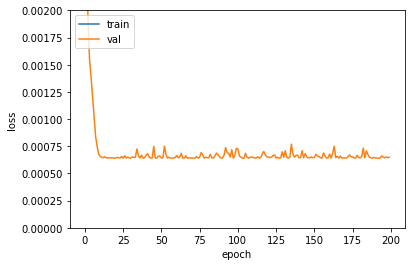

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0.0, 0.002)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 0.62 RMSE


**RMSE 수치는 오차범위를 뜻한다.  
리플 가격이 212원 정도인데 오차범위가 0.62원 정도 될 수 있다는 뜻이다.**

In [14]:
# 다음날 종가 예측
lastX = ndf[-1]
lastX

array([-2.727273], dtype=float32)

In [15]:
lastX = np.reshape(lastX, (1, 1, 1))
lastX

array([[[-2.727273]]], dtype=float32)

In [16]:
lastY = model.predict(lastX)

In [17]:
lastY = scaler.inverse_transform(lastY)
print('입력된 마지막 데이터의 1분후 예측가격: %.1f' % lastY)

입력된 마지막 데이터의 1분후 예측가격: 211.1


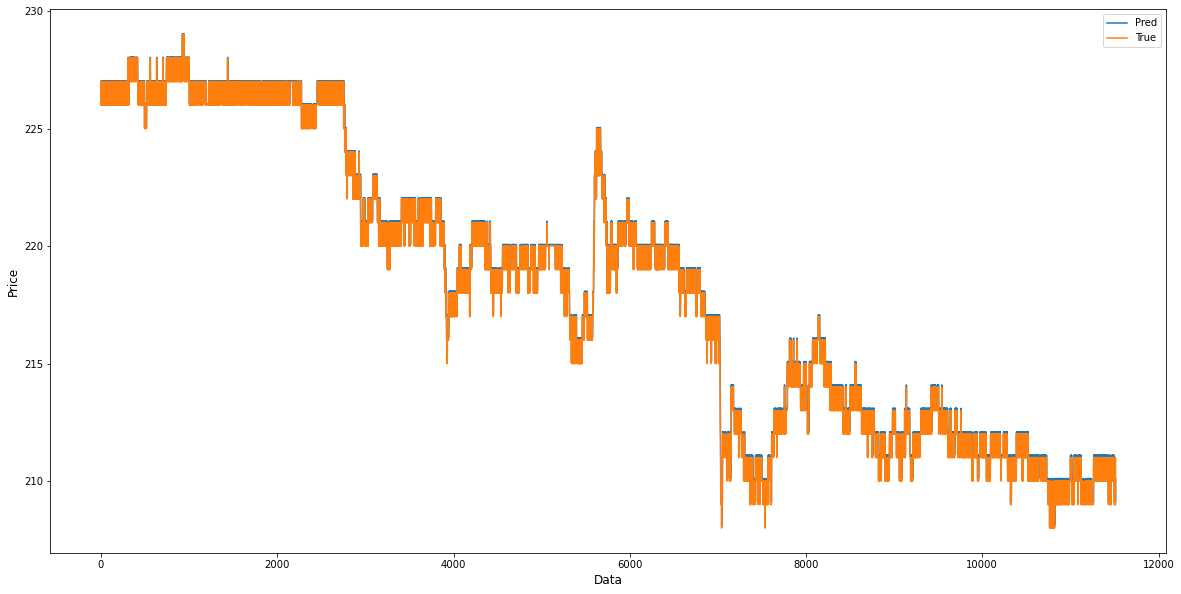

In [18]:
# 시각화
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(testPredict,label='Pred')
plt.plot(testY,label='True')
ax.legend()
plt.xlabel('Data', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

보조 지표 칼럼을 사용하지않고 종가 데이터로만 학습을 시켰는데 오히려 로스가 줄었다.  
보조 지표는 별 도움이 되지 않는 것인가.. 

**논문에 보조 지표보다는 환율, 환율 이동평균, 전 산업 생산지수등 환경 예측요소를 사용할 때, 예측율이 상승한다고 나와있다.  
(+ DNN은 느리고 오차율이 커서 사용하지 말것)**  

## ***따라서 주가 예측에 대한 오차율을 줄이기 위해서는***
## ***보다 다양한 실험을 통해 적절한 [환경]예측요소들을 선택해야 할 것이다.***  